In [98]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import norm
import math
from dateutil.relativedelta import relativedelta
import calendar
import holidays
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re

In [184]:
#df_vol = pd.read_excel('/Users/jacky/Python Shit/Trading/4370 project/S&P500_10Y_HP_Vol30D.xlsx', index_col=0)
#df_vol = pd.read_excel('/Users/jacky/Python Shit/Trading/4370 project/S&P500_10Y_HP_Vol90D.xlsx', index_col=0)
df_vol = pd.read_excel('/Users/jacky/Python Shit/Trading/4370 project/S&P500_10Y_HP_IVOL_Delta.xlsx', index_col=0)

df_price = pd.read_excel('/Users/jacky/Python Shit/Trading/4370 project/S&P500_10Y_HP_HP.xlsx', index_col=0)
df_expiration_date = pd.read_excel('/Users/jacky/Python Shit/Trading/4370 project/Contract_expiration.xlsx')
df_earning_date = pd.read_csv('/Users/jacky/Python Shit/Trading/4370 project/Earning Date1.csv')
df_interest_rate = pd.read_excel('/Users/jacky/Python Shit/Trading/4370 project/Interest_rate.xlsx')

df_expiration_date = pd.to_datetime(df_expiration_date['Contract_expiration'])


In [185]:
selected_symbol = ['NVDA US EQUITY','ORCL US EQUITY','PANW US EQUITY', 'TGT US EQUITY', 'NFLX US EQUITY','ANET US EQUITY','AMZN US EQUITY', 'NKE US EQUITY', 'DELL US EQUITY','FTNT US EQUITY']

selected_price = df_price[selected_symbol]
selected_vol = df_vol[selected_symbol]

selected_price.reset_index(inplace=True)
selected_vol.reset_index(inplace=True)

selected_price['index'] = pd.to_datetime(selected_price['index'])
selected_vol['index'] = pd.to_datetime(selected_vol['index'])

#Rename the symbol
selected_price = selected_price.rename(columns={'index' : 'time',
                                                'NVDA US EQUITY'    : 'NVDA',
                                                'ORCL US EQUITY'    : 'ORCL',
                                                'PANW US EQUITY'    : 'PANW',
                                                'TGT US EQUITY'     : 'TGT',
                                                'NFLX US EQUITY'    : 'NFLX',
                                                'ANET US EQUITY'    : 'ANET',
                                                'AMZN US EQUITY'    : 'AMZN',
                                                'NKE US EQUITY'     : 'NKE',
                                                'DELL US EQUITY'    : 'DELL',
                                                'FTNT US EQUITY'    : 'FTNT'})

selected_vol = selected_vol.rename(columns={'index' : 'time',
                                            'NVDA US EQUITY'    : 'NVDA',
                                            'ORCL US EQUITY'    : 'ORCL',
                                            'PANW US EQUITY'    : 'PANW',
                                            'TGT US EQUITY'     : 'TGT',
                                            'NFLX US EQUITY'    : 'NFLX',
                                            'ANET US EQUITY'    : 'ANET',
                                            'AMZN US EQUITY'    : 'AMZN',
                                            'NKE US EQUITY'     : 'NKE',
                                            'DELL US EQUITY'    : 'DELL',
                                            'FTNT US EQUITY'    : 'FTNT'})

# Extract data from the previous earnings report 
df_earning_date['Earnings Date'] = pd.to_datetime(df_earning_date['Earnings Date'])
df_earning_date = df_earning_date[df_earning_date['Earnings Date'] <= pd.Timestamp("2024-11-05")]
df_earning_date = df_earning_date[df_earning_date['Earnings Date'] >= pd.Timestamp("2021-11-08")]
df_earning_date = df_earning_date.sort_values(by='Earnings Date')

# Filter the df_earning_date that DELL have earning report but without stock price
mask = (df_earning_date["Symbol"] == "DELL") & (df_earning_date["Earnings Date"] >= pd.Timestamp('2019-01-01')) 
mask_not_dell = (df_earning_date["Symbol"] != "DELL")
final_mask = mask | mask_not_dell
filtered_df_earning_date = df_earning_date[final_mask]

/var/folders/rr/glggxg997qbgnyw1d_r00sj80000gn/T/ipykernel_1140/2773258482.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_price['index'] = pd.to_datetime(selected_price['index'])
/var/folders/rr/glggxg997qbgnyw1d_r00sj80000gn/T/ipykernel_1140/2773258482.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_vol['index'] = pd.to_datetime(selected_vol['index'])


In [101]:
# Black Scholes Model 
def black_scholes(stock_price, strike_price, time_to_expiration_days, risk_free_rate, volatility,dividend_yield=0):
    # Calculate the d1 and d2 values
    time_to_expiration = time_to_expiration_days / 365

    d1 = (math.log(stock_price / strike_price) + (risk_free_rate - dividend_yield + (volatility ** 2) / 2) * time_to_expiration) / (volatility * math.sqrt(time_to_expiration))
    d2 = d1 - volatility * math.sqrt(time_to_expiration)

    # Calculate the call and put prices
    call_price = stock_price * math.exp(-dividend_yield * time_to_expiration) * norm.cdf(d1) - strike_price * math.exp(-risk_free_rate * time_to_expiration) * norm.cdf(d2)
    put_price = strike_price * math.exp(-risk_free_rate * time_to_expiration) * norm.cdf(-d2) - stock_price * math.exp(-dividend_yield * time_to_expiration) * norm.cdf(-d1)

    # Calculate delta
    delta_call = math.exp(-dividend_yield * time_to_expiration) * norm.cdf(d1)
    delta_put = math.exp(-dividend_yield * time_to_expiration) * (norm.cdf(d1) - 1)

    # Calculate vega
    vega = stock_price * math.exp(-dividend_yield * time_to_expiration) * norm.pdf(d1) * math.sqrt(time_to_expiration)/100

    # Calculate gamma
    gamma = norm.pdf(d1) / (stock_price * volatility * math.sqrt(time_to_expiration))

    # Calculate theta
    theta_call = -(stock_price * volatility * math.exp(-dividend_yield * time_to_expiration) * norm.pdf(d1)) / (2 * math.sqrt(time_to_expiration)) - risk_free_rate * strike_price * math.exp(-risk_free_rate * time_to_expiration) * norm.cdf(d2) + dividend_yield * stock_price * math.exp(-dividend_yield * time_to_expiration) * norm.cdf(d1)
    theta_put = -(stock_price * volatility * math.exp(-dividend_yield * time_to_expiration) * norm.pdf(d1)) / (2 * math.sqrt(time_to_expiration)) + risk_free_rate * strike_price * math.exp(-risk_free_rate * time_to_expiration) * norm.cdf(-d2) - dividend_yield * stock_price * math.exp(-dividend_yield * time_to_expiration) * norm.cdf(-d1)

    #return call_price, put_price, delta_call, delta_put, vega, gamma, theta_call, theta_put
    # Create a dictionary with the results
    results = {
        'Call_Price': call_price,
        'Put_Price': put_price,
        'Delta_Call': delta_call,
        'Delta_Put': delta_put,
        'Vega': vega,
        'Gamma': gamma,
        'Theta_Call': theta_call,
        'Theta_Put': theta_put
    }

    return pd.DataFrame(results, index=[0])

In [520]:
def straddle(stock_name,earnings_date,maturity_1,n, bidask=0 ,diff = 0):
    # Find the time before earnings date by n trading days
    temp = selected_price[stock_name].loc[selected_price['time'] == earnings_date].idxmax() - n
    time = pd.to_datetime(selected_price['time'].loc[temp])

    location1 = None
    #Find the stock price's index when shorter term call and longer term call expired 
    #location1 = selected_price[stock_name].loc[selected_price['time'] == maturity_1].idxmax()
    i = 0
    while location1 is None:
        filtered_data = selected_price[selected_price['time'] == (maturity_1 + pd.Timedelta(days=i))]
        i += 1
        if not filtered_data.empty:
            location1 = filtered_data[stock_name].idxmax()
        
    
    # Find the stock price when time = earnings date by n trading day 
    s = selected_price[stock_name].iloc[temp]
    # Find the stirke price of time (Assume ATM)
    k = round(s)
    # Find the IV when time = earnings date by n trading day 
    vol = selected_vol[stock_name].iloc[temp]
    #Find the time to maturity for those 2 calls
    t1 = location1 - temp
    #Find the interest rate 
    interest = df_interest_rate['10 Year Treasury Yield'].iloc[temp-1829]/100

    # Calculate the price when calendar spread is bought (Price of shorter term call - Price of long term call)
    # If the calendar cost is negative, then it is a option premium
    straddle_cost = black_scholes(s,(k-diff),t1,interest,vol/100)['Call_Price']*(1+bidask/100) + black_scholes(s,(k+diff),t1,interest,vol/100)['Put_Price']*(1+bidask/100)

    # PnL when both exercise is maturity 
    pnl = max(0,selected_price[stock_name].iloc[location1] - (k-diff)) + max(0,(k+diff) - selected_price[stock_name].iloc[location1]) - straddle_cost

    results= {
            'trading_date': time.strftime('%Y-%m-%d'),
            'earning_date': earnings_date.strftime('%Y-%m-%d'),
            'calendar_contract': maturity_1.strftime('%Y-%m-%d'),
            'stock name': stock_name,
            'straddle_cost' : straddle_cost,
            'long call': max(0,selected_price[stock_name].iloc[location1] - (k-diff)),
            'long put':max(0,(k+diff) - selected_price[stock_name].iloc[location1]),
            'expiration date': pd.to_datetime(selected_price['time'].loc[location1]).strftime('%Y-%m-%d'),
            'holding_period': t1,
            'pnl': pnl
    }

    return pd.DataFrame(results, index=[0])

In [521]:
straddle("DELL",pd.Timestamp('2024-09-09'),pd.Timestamp('2024-10-18'),7,5, diff = 0)

,trading_date,earning_date,calendar_contract,stock name,straddle_cost,long call,long put,expiration date,holding_period,pnl
0,2024-08-29,2024-09-09,2024-10-18,DELL,20.198813,16.0122,0,2024-10-18,36,-4.186613


In [390]:
def long_calendar_spread_not_hold(stock_name,earnings_date,maturity_1,maturity_2,n, bidask, diff=0):
    # Find the time before earnings date by n trading days
    temp = selected_price[stock_name].loc[selected_price['time'] == maturity_1].idxmax() - n
    time = pd.to_datetime(selected_price['time'].loc[temp])

    location1 = None
    location2 = None
    #Find the stock price's index when shorter term call and longer term call expired 
    i = 0
    while location1 is None:
        filtered_data = selected_price[selected_price['time'] == (maturity_1 + pd.Timedelta(days=i))]
        i += 1
        if not filtered_data.empty:
            location1 = filtered_data[stock_name].idxmax()
        

    i = 0
    while location2 is None:
        filtered_data = selected_price[selected_price['time'] == (maturity_2 + pd.Timedelta(days=i))]
        i += 1
        if not filtered_data.empty:
            location2 = filtered_data[stock_name].idxmax()
        
    
    # Find the stock price when time = earnings date by n trading day 
    s = selected_price[stock_name].iloc[temp]
    # Find the stirke price of time (Assume ATM)
    k = round(s)
    # Find the IV when time = earnings date by n trading day 
    vol = selected_vol[stock_name].iloc[temp]
    #Find the time to maturity for those 2 calls
    t1 = location1 - temp
    t2 = location2 - temp
    #Find the interest rate 
    interest = df_interest_rate['10 Year Treasury Yield'].iloc[temp-1829]/100

    #Find stock price and volatility at location1
    s1 = selected_price[stock_name].iloc[location1]
    vol1 = selected_vol[stock_name].iloc[location1]

    # Calculate the price when calendar spread is bought (Price of shorter term call - Price of long term call)
    # If the calendar cost is negative, then it is a option premium
    calendar_cost = - black_scholes(s,k,t1,interest,vol/100)['Call_Price']*(1-bidask/100) + black_scholes(s,k,t2,interest,vol/100)['Call_Price']*(1+bidask/100) - black_scholes(s1,k,t2-t1,interest,vol1/100)["Call_Price"]*(1-bidask/100)

    # PnL when both shorter term is expirated
    pnl = min(0,k - selected_price[stock_name].iloc[location1]) - calendar_cost

    results= {
            'trading_date': time.strftime('%Y-%m-%d'),
            'earning_date': earnings_date.strftime('%Y-%m-%d'),
            'calendar_contract': maturity_1.strftime('%Y-%m-%d') +', '+maturity_2.strftime('%Y-%m-%d'),
            'stock name': stock_name,
            'initial_cost' : - black_scholes(s,k,t1,0.05,vol/100)['Call_Price'] + black_scholes(s,k,t2,0.05,vol/100)['Call_Price'],
            'calendar_cost' : calendar_cost,
            'short call': min(0,k - selected_price[stock_name].iloc[location1]),
            'option premium for sell longer term': black_scholes(s1,k,t2-t1,0.05,vol1/100)["Call_Price"],
            'expiration date' :pd.to_datetime(selected_price['time'].loc[location1]).strftime('%Y-%m-%d'),
            'holding_period': t1,
            'pnl': pnl
    }

    return pd.DataFrame(results, index=[0])

In [359]:
# number of days before earning report
n = 5
stock = ['NVDA','ORCL','PANW','TGT','NFLX','ANET','AMZN','NKE','DELL','FTNT']
result = pd.DataFrame()
for i in stock:
    for earning_date in filtered_df["Earnings Date"][filtered_df["Symbol"]==i]:
        closest_maturity = df_expiration_date.loc[(df_expiration_date - earning_date).abs().idxmin()] #+1
        longer_maturity = df_expiration_date.loc[(df_expiration_date - earning_date).abs().idxmin()+1] #+2
        if longer_maturity <= earning_date:
            longer_maturity = df_expiration_date.loc[(df_expiration_date - earning_date).abs().idxmin()+2] #+2
        if closest_maturity == pd.Timestamp("2024-11-15"):
            continue
        if longer_maturity >= pd.Timestamp("2024-10-21"):
            longer_maturity = closest_maturity
        result = pd.concat([result,long_calendar_spread_not_hold(i,earning_date,closest_maturity,longer_maturity,n)], axis = 0)

result

/var/folders/rr/glggxg997qbgnyw1d_r00sj80000gn/T/ipykernel_1140/490106222.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (math.log(stock_price / strike_price) + (risk_free_rate - dividend_yield + (volatility ** 2) / 2) * time_to_expiration) / (volatility * math.sqrt(time_to_expiration))
/var/folders/rr/glggxg997qbgnyw1d_r00sj80000gn/T/ipykernel_1140/490106222.py:21: RuntimeWarning: invalid value encountered in scalar divide
  gamma = norm.pdf(d1) / (stock_price * volatility * math.sqrt(time_to_expiration))
/var/folders/rr/glggxg997qbgnyw1d_r00sj80000gn/T/ipykernel_1140/490106222.py:24: RuntimeWarning: invalid value encountered in scalar divide
  theta_call = -(stock_price * volatility * math.exp(-dividend_yield * time_to_expiration) * norm.pdf(d1)) / (2 * math.sqrt(time_to_expiration)) - risk_free_rate * strike_price * math.exp(-risk_free_rate * time_to_expiration) * norm.cdf(d2) + dividend_yield * stock_price * math.exp(-dividend_yield * time_to_expiration) *

,trading_date,earning_date,calendar_contract,stock name,initial_cost,calendar_cost,short call,option premium for sell longer term,expiration date,holding_period,pnl
0,2023-02-10,2023-02-22,"2023-02-17, 2023-03-17",NVDA,0.738785,-0.935328,-0.3740,1.674368,2023-02-17,5,0.561328
0,2023-05-12,2023-05-24,"2023-05-19, 2023-06-16",NVDA,0.511214,-3.410223,-3.2488,3.926264,2023-05-19,5,0.161423
0,2023-08-11,2023-08-23,"2023-08-18, 2023-09-15",NVDA,1.029500,-4.224060,-2.2824,5.254900,2023-08-18,5,1.941660
0,2023-11-10,2023-11-21,"2023-11-17, 2023-12-15",NVDA,1.087822,-3.223548,-1.2831,4.311504,2023-11-17,5,1.940448
0,2024-02-09,2024-02-21,"2024-02-16, 2024-03-15",NVDA,1.686035,-6.198138,-0.5975,7.883177,2024-02-16,5,5.600638
...,...,...,...,...,...,...,...,...,...,...,...
0,2023-07-14,2023-08-03,"2023-07-21, 2023-08-18",FTNT,1.341803,-0.476773,0.0000,1.815505,2023-07-21,5,0.476773
0,2023-10-13,2023-11-02,"2023-10-20, 2023-11-17",FTNT,1.168260,-0.067232,0.0000,1.233992,2023-10-20,5,0.067232
0,2024-02-09,2024-02-06,"2024-02-16, 2024-03-15",FTNT,1.254729,-0.173790,0.0000,1.424019,2024-02-16,5,0.173790
0,2024-04-12,2024-05-02,"2024-04-19, 2024-05-17",FTNT,1.319088,0.273972,0.0000,1.041330,2024-04-19,5,-0.273972


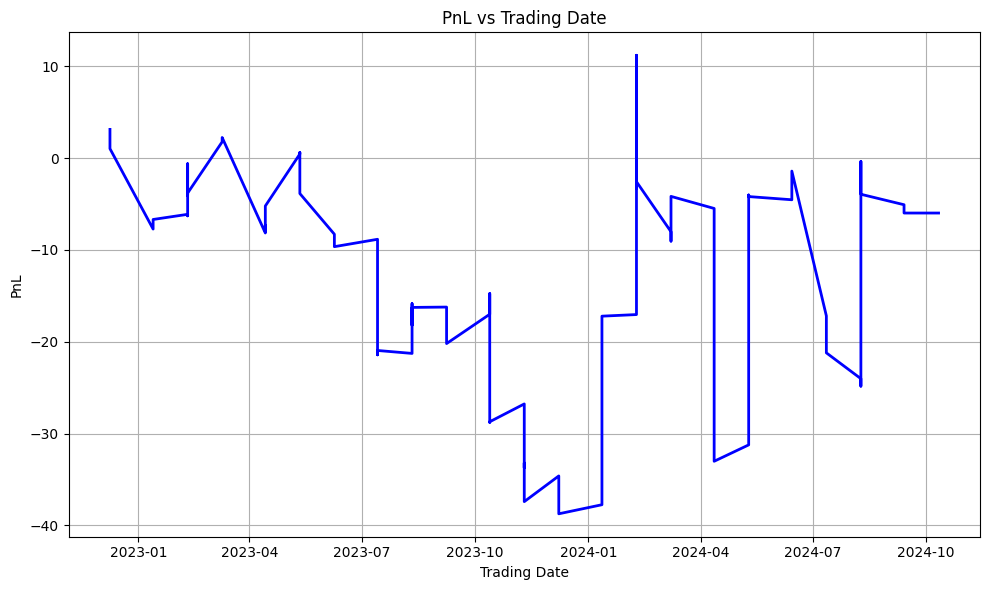

In [360]:
result = result.sort_values(by='trading_date')
result['cumsum'] = result['pnl'].cumsum()
result = result.reset_index(drop=True)
result['trading_date'] = pd.to_datetime(result['trading_date'])
plt.figure(figsize=(10, 6))
plt.plot(result['trading_date'], result['cumsum'], color='b', linestyle='-', linewidth=2)

#label
plt.xlabel('Trading Date')
plt.ylabel('PnL')
plt.title('PnL vs Trading Date')

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()

In [621]:
def calendar_spread_not_hold(stock_name,earnings_date,maturity_1,maturity_2,n,bidask = 0, diff=0):
    # Find the time before earnings date by n trading days
    temp = selected_price[stock_name].loc[selected_price['time'] == earnings_date].idxmax() - n
    time = pd.to_datetime(selected_price['time'].loc[temp])

    location1 = None
    location2 = None
    #Find the stock price's index when shorter term call and longer term call expired 
    i = 0
    while location1 is None:
        filtered_data = selected_price[selected_price['time'] == (maturity_1 + pd.Timedelta(days=i))]
        i += 1
        if not filtered_data.empty:
            location1 = filtered_data[stock_name].idxmax()
        

    i = 0
    while location2 is None:
        filtered_data = selected_price[selected_price['time'] == (maturity_2 + pd.Timedelta(days=i))]
        i += 1
        if not filtered_data.empty:
            location2 = filtered_data[stock_name].idxmax()
        
    
    # Find the stock price when time = earnings date by n trading day 
    s = selected_price[stock_name].iloc[temp]
    # Find the stirke price of time (Assume ATM)
    k = round(s)
    # Find the IV when time = earnings date by n trading day 
    vol = selected_vol[stock_name].iloc[temp]
    #Find the time to maturity for those 2 calls
    t1 = location1 - temp
    t2 = location2 - temp

    interest = df_interest_rate['10 Year Treasury Yield'].iloc[temp-1829]/100
    interest2 = df_interest_rate['10 Year Treasury Yield'].iloc[location1-1829]/100

    #Find stock price and volatility at location1
    s1 = selected_price[stock_name].iloc[location1]
    vol1 = selected_vol[stock_name].iloc[location1]

    # Calculate the price when calendar spread is bought (Price of shorter term call - Price of long term call)
    # If the calendar cost is negative, then it is a option premium
    calendar_cost = black_scholes(s,(k-diff),t1,interest,vol/100)['Call_Price']*(1+bidask/100) - black_scholes(s,(k+diff),t2,interest,vol/100)['Call_Price']*(1-bidask/100) + black_scholes(s1,(k+diff),t2-t1,interest2,vol1/100)["Call_Price"]*(1+bidask/100)

    # PnL when both shorter term is expirated
    pnl = max(0,selected_price[stock_name].iloc[location1] - (k-diff)) - calendar_cost

    results= {
            'trading_date': time.strftime('%Y-%m-%d'),
            'earning_date': earnings_date.strftime('%Y-%m-%d'),
            'calendar_contract': maturity_1.strftime('%Y-%m-%d') +', '+maturity_2.strftime('%Y-%m-%d'),
            'stock name': stock_name,
            'calendar_cost' : -calendar_cost,
            'long call': max(0,selected_price[stock_name].iloc[location1] - (k-diff)),
            'cost of call at maurity 1': black_scholes(s1,(k+diff),t2-t1,0.05,vol1/100)["Call_Price"],
            'expiration date' :pd.to_datetime(selected_price['time'].loc[location1]).strftime('%Y-%m-%d'),
            'holding_period': t1,
            'pnl': pnl
    }

    return pd.DataFrame(results, index=[0])

In [394]:
def calendar_hold(stock_name,earnings_date,maturity_1,maturity_2,n, bidask=0,diff=0):
    # Find the time before earnings date by n trading days
    temp = selected_price[stock_name].loc[selected_price['time'] == earnings_date].idxmax() - n
    time = pd.to_datetime(selected_price['time'].loc[temp])

    location1 = None
    location2 = None
    #Find the stock price's index when shorter term call and longer term call expired 
    i = 0
    while location1 is None:
        filtered_data = selected_price[selected_price['time'] == (maturity_1 + pd.Timedelta(days=i))]
        i += 1
        if not filtered_data.empty:
            location1 = filtered_data[stock_name].idxmax()
        

    i = 0
    while location2 is None:
        filtered_data = selected_price[selected_price['time'] == (maturity_2 + pd.Timedelta(days=i))]
        i += 1
        if not filtered_data.empty:
            location2 = filtered_data[stock_name].idxmax()
        
    
    # Find the stock price when time = earnings date by n trading day 
    s = selected_price[stock_name].iloc[temp]
    # Find the stirke price of time (Assume ATM)
    k = round(s)
    # Find the IV when time = earnings date by n trading day 
    vol = selected_vol[stock_name].iloc[temp]
    #Find the time to maturity for those 2 calls
    t1 = location1 - temp
    t2 = location2 - temp

    interest = df_interest_rate['10 Year Treasury Yield'].iloc[temp-1829]/100


    # Calculate the price when calendar spread is bought (Price of shorter term call - Price of long term call)
    # If the calendar cost is negative, then it is a option premium
    calendar_cost = black_scholes(s,k,t1,interest,vol/100)['Call_Price']*(1+bidask/100) - black_scholes(s,k,t2,interest,vol/100)['Call_Price']*(1-bidask/100)

    # PnL when both exercise is maturity 
    pnl = max(0,selected_price[stock_name].iloc[location1] - k) + min(0,k - selected_price[stock_name].iloc[location2]) - calendar_cost

    results= {
            'trading_date': time.strftime('%Y-%m-%d'),
            'earning_date': earnings_date.strftime('%Y-%m-%d'),
            'calendar_contract': maturity_1.strftime('%Y-%m-%d') +', '+maturity_2.strftime('%Y-%m-%d'),
            'stock name': stock_name,
            'calendar_cost' : calendar_cost,
            'long call': max(0,selected_price[stock_name].iloc[location1] - (k-diff)),
            'short call':min(0,(k+diff) - selected_price[stock_name].iloc[location2]),
            'expiration date' :pd.to_datetime(selected_price['time'].loc[location2]).strftime('%Y-%m-%d'),
            'holding_period': t2,
            'pnl': pnl
    }

    return pd.DataFrame(results, index=[0])

In [624]:
filtered_df = filtered_df_earning_date
# number of days before earning report
n = 5
stock = ['NVDA','ORCL','PANW','TGT','NFLX','ANET','AMZN','NKE','DELL','FTNT']
result = pd.DataFrame()
for i in stock:
    for earning_date in filtered_df["Earnings Date"][filtered_df["Symbol"]==i]:
        closest_maturity = df_expiration_date.loc[(df_expiration_date - earning_date).abs().idxmin()] #+1
        longer_maturity = df_expiration_date.loc[(df_expiration_date - earning_date).abs().idxmin()+1] #+2
        if closest_maturity <= earning_date:
            closest_maturity = df_expiration_date.loc[(df_expiration_date - earning_date).abs().idxmin()+1] #+1
            longer_maturity = df_expiration_date.loc[(df_expiration_date - earning_date).abs().idxmin()+2] #+2
        if closest_maturity == pd.Timestamp("2024-11-15"):
            continue
        if longer_maturity >= pd.Timestamp("2024-10-20"):
            longer_maturity = closest_maturity
        result = pd.concat([result,calendar_spread_not_hold(i,earning_date,closest_maturity,longer_maturity,n)], axis = 0)

result= result.sort_values(by='trading_date')
result['cumsum'] = result['pnl'].cumsum()
result = result.reset_index(drop=True)
result['trading_date'] = pd.to_datetime(result['trading_date'])
result.to_excel('backtest_result.xlsx')

/var/folders/rr/glggxg997qbgnyw1d_r00sj80000gn/T/ipykernel_1140/490106222.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (math.log(stock_price / strike_price) + (risk_free_rate - dividend_yield + (volatility ** 2) / 2) * time_to_expiration) / (volatility * math.sqrt(time_to_expiration))
/var/folders/rr/glggxg997qbgnyw1d_r00sj80000gn/T/ipykernel_1140/490106222.py:21: RuntimeWarning: invalid value encountered in scalar divide
  gamma = norm.pdf(d1) / (stock_price * volatility * math.sqrt(time_to_expiration))
/var/folders/rr/glggxg997qbgnyw1d_r00sj80000gn/T/ipykernel_1140/490106222.py:24: RuntimeWarning: invalid value encountered in scalar divide
  theta_call = -(stock_price * volatility * math.exp(-dividend_yield * time_to_expiration) * norm.pdf(d1)) / (2 * math.sqrt(time_to_expiration)) - risk_free_rate * strike_price * math.exp(-risk_free_rate * time_to_expiration) * norm.cdf(d2) + dividend_yield * stock_price * math.exp(-dividend_yield * time_to_expiration) *

In [395]:
def diagonal_not_hold(stock_name,earnings_date,maturity_1,maturity_2,n,bidask=0 ,diff=0):
    # Find the time before earnings date by n trading days
    temp = selected_price[stock_name].loc[selected_price['time'] == earnings_date].idxmax() - n
    time = pd.to_datetime(selected_price['time'].loc[temp])

    location1 = None
    location2 = None
    #Find the stock price's index when shorter term call and longer term call expired 
    i = 0
    while location1 is None:
        filtered_data = selected_price[selected_price['time'] == (maturity_1 + pd.Timedelta(days=i))]
        i += 1
        if not filtered_data.empty:
            location1 = filtered_data[stock_name].idxmax()
        

    i = 0
    while location2 is None:
        filtered_data = selected_price[selected_price['time'] == (maturity_2 + pd.Timedelta(days=i))]
        i += 1
        if not filtered_data.empty:
            location2 = filtered_data[stock_name].idxmax()
        
    
    # Find the stock price when time = earnings date by n trading day 
    s = selected_price[stock_name].iloc[temp]
    #Find the strike price with diff $ of k
    k1 = round(selected_price[stock_name].iloc[temp]* (1-(diff/100)))
    k2 = round(selected_price[stock_name].iloc[temp]* (1+(diff/100)))


    # Find the IV when time = earnings date by n trading day 
    vol = selected_vol[stock_name].iloc[temp]
    #Find the time to maturity for those 2 calls
    t1 = location1 - temp
    t2 = location2 - temp

    interest = df_interest_rate['10 Year Treasury Yield'].iloc[temp-1829]/100
    interest2 = df_interest_rate['10 Year Treasury Yield'].iloc[location1-1829]/100

    #Find stock price and volatility at location1
    s1 = selected_price[stock_name].iloc[location1]
    vol1 = selected_vol[stock_name].iloc[location1]

    # Calculate the price when calendar spread is bought (Price of shorter term call - Price of long term call)
    # If the calendar cost is negative, then it is a option premium
    calendar_cost = black_scholes(s,k1,t1,interest,vol/100)['Call_Price']*(1+bidask/100) - black_scholes(s,k2,t2,interest,vol/100)['Call_Price']*(1-bidask/100) + black_scholes(s1,k2,t2-t1,interest2,vol1/100)["Call_Price"]*(1+bidask/100)

    # PnL when both shorter term is expirated
    pnl = max(0,selected_price[stock_name].iloc[location1] - k1) - calendar_cost

    results= {
            'trading_date': time.strftime('%Y-%m-%d'),
            'earning_date': earnings_date.strftime('%Y-%m-%d'),
            'calendar_contract': maturity_1.strftime('%Y-%m-%d') +', '+maturity_2.strftime('%Y-%m-%d'),
            'stock name': stock_name,
            'calendar_cost' : calendar_cost,
            'long call': max(0,selected_price[stock_name].iloc[location1] - k1),
            'cost of call at maurity 1': black_scholes(s1,k2,t2-t1,0.05,vol1/100)["Call_Price"],
            'expiration date' :pd.to_datetime(selected_price['time'].loc[location1]).strftime('%Y-%m-%d'),
            'holding_period': t1,
            'pnl': pnl
    }

    return pd.DataFrame(results, index=[0])

In [396]:
def diagonal_hold(stock_name,earnings_date,maturity_1,maturity_2,n,bidask=0 ,diff=0):
    # Find the time before earnings date by n trading days
    temp = selected_price[stock_name].loc[selected_price['time'] == earnings_date].idxmax() - n
    time = pd.to_datetime(selected_price['time'].loc[temp])

    location1 = None
    location2 = None
    #Find the stock price's index when shorter term call and longer term call expired 
    i = 0
    while location1 is None:
        filtered_data = selected_price[selected_price['time'] == (maturity_1 + pd.Timedelta(days=i))]
        i += 1
        if not filtered_data.empty:
            location1 = filtered_data[stock_name].idxmax()
        

    i = 0
    while location2 is None:
        filtered_data = selected_price[selected_price['time'] == (maturity_2 + pd.Timedelta(days=i))]
        i += 1
        if not filtered_data.empty:
            location2 = filtered_data[stock_name].idxmax()
        
    
    # Find the stock price when time = earnings date by n trading day 
    s = selected_price[stock_name].iloc[temp]
    #Find the strike price with diff $ of k
    k1 = round(selected_price[stock_name].iloc[temp]* (1-(diff/100)))
    k2 = round(selected_price[stock_name].iloc[temp]* (1+(diff/100)))


    # Find the IV when time = earnings date by n trading day 
    vol = selected_vol[stock_name].iloc[temp]
    #Find the time to maturity for those 2 calls
    t1 = location1 - temp
    t2 = location2 - temp

    interest = df_interest_rate['10 Year Treasury Yield'].iloc[temp-1829]/100

    calendar_cost = black_scholes(s,k1,t1,interest,vol/100)['Call_Price']*(1+bidask/100) - black_scholes(s,k2,t2,interest,vol/100)['Call_Price']*(1-bidask/100)

    pnl = max(0,selected_price[stock_name].iloc[location1] - k1) + min(0,(k2 - selected_price[stock_name].iloc[location2])) - calendar_cost

    # PnL when both shorter term is expirated

    results= {
            'trading_date': time.strftime('%Y-%m-%d'),
            'earning_date': earnings_date.strftime('%Y-%m-%d'),
            'calendar_contract': maturity_1.strftime('%Y-%m-%d') +', '+maturity_2.strftime('%Y-%m-%d'),
            'stock name': stock_name,
            'calendar_cost' : calendar_cost,
            'long call': max(0,selected_price[stock_name].iloc[location1] - k1),
            'short call': min(0,(k2 - selected_price[stock_name].iloc[location2])),
            'expiration date' :pd.to_datetime(selected_price['time'].loc[location2]).strftime('%Y-%m-%d'),
            'holding_period': t2,
            'pnl': pnl
    }

    return pd.DataFrame(results, index=[0])

In [ ]:
testing = Portfolio(10000)

n = 5
stock = ['NVDA','ORCL','PANW','TGT','NFLX','ANET','AMZN','NKE','DELL','FTNT']
result = pd.DataFrame()
for i in stock:
    for earning_date in filtered_df["Earnings Date"][filtered_df["Symbol"]==i]:
        closest_maturity = df_expiration_date.loc[(df_expiration_date - earning_date).abs().idxmin()] #+1
        longer_maturity = df_expiration_date.loc[(df_expiration_date - earning_date).abs().idxmin()+1] #+2
        if longer_maturity <= earning_date:
            longer_maturity = df_expiration_date.loc[(df_expiration_date - earning_date).abs().idxmin()+2] #+2
        if closest_maturity == pd.Timestamp("2024-11-15"):
            continue
        if longer_maturity >= pd.Timestamp("2024-10-21"):
            longer_maturity = closest_maturity
        testing.execute_long_calendar_not_hold(i,earning_date,closest_maturity,longer_maturity,n,5)

plt.figure(figsize=(10, 6))
#Standardise the output result for plotting
equity_history_float = [float(item) for item in testing.equity_history]
equity_history_array = np.array(equity_history_float)

#Standardise the result
extracted_dates = []
for item in testing.transactions:
    dates = re.findall(r'\d{4}-\d{2}-\d{2}', str(item))
    extracted_dates.extend(dates)
sorted_dates = sorted(extracted_dates)
converted_dates = pd.to_datetime(sorted_dates)

#Plotting the PNL chart
plt.plot(converted_dates, equity_history_array, color='b', linestyle='-',label='straddle', linewidth=2)

In [598]:
class Portfolio:
    def __init__(self, cash):
        self.cash = cash
        self.equity = cash
        self.equity_history = [cash]  # Store the equity values over time
        self.options_equity = 0
        self.transactions = ['2021-11-08']# Store transaction details (date)
        self.max_options = int(self.equity / 100)
        self.pnl_history = []

    def update_portfolio(self, options_pnl, cost, trading_date, expiration_date):
        self.equity += options_pnl* self.max_options
        self.options_equity += options_pnl* self.max_options
        self.transactions.append(trading_date)
        self.equity_history.append(self.equity.copy())

        # Update PNL history
        self.pnl_history.append(options_pnl)

    def execute_straddle(self, stock_name, earnings_date, maturity_1, n,bidask_spread ,diff=0):
        options_data = straddle(stock_name, earnings_date, maturity_1, n,bidask_spread)
        cost = options_data['straddle_cost']
        options_pnl = options_data['pnl']
        trading_date = options_data['trading_date']
        expiration_date = options_data['expiration date']
        self.update_portfolio(options_pnl, cost, trading_date, expiration_date)

    
    def execute_calendar_not_hold(self, stock_name, earnings_date, maturity_1, maturity_2, n,bidask_spread ,diff=0):
        options_data = calendar_spread_not_hold(stock_name, earnings_date, maturity_1, maturity_2, n,bidask_spread)
        options_pnl = options_data['pnl']
        cost = options_data['calendar_cost']
        trading_date = options_data['trading_date']
        expiration_date = options_data['expiration date']
        self.update_portfolio(options_pnl, cost, trading_date, expiration_date)
    
    def execute_calendar_hold(self, stock_name, earnings_date, maturity_1, maturity_2, n, bidask_spread,diff=0):
        options_data = calendar_hold(stock_name, earnings_date, maturity_1, maturity_2,n,bidask_spread)
        options_pnl = options_data['pnl']
        cost = options_data['calendar_cost']
        trading_date = options_data['trading_date']
        expiration_date = options_data['expiration date']
        self.update_portfolio(options_pnl, cost, trading_date, expiration_date)

    def execure_diagonal_not_hold(self, stock_name, earnings_date, maturity_1, maturity_2, n,bidask_spread, diff=0):
        options_data = diagonal_not_hold(stock_name, earnings_date, maturity_1, maturity_2,n, bidask_spread,diff)
        options_pnl = options_data['pnl']
        cost = options_data['calendar_cost']
        trading_date = options_data['trading_date']
        expiration_date = options_data['expiration date']
        self.update_portfolio(options_pnl, cost, trading_date, expiration_date)

    def execute_digaonal_hold(self, stock_name, earnings_date, maturity_1, maturity_2, n, bidask_spread,diff=0):
        options_data = diagonal_hold(stock_name, earnings_date, maturity_1, maturity_2, n, bidask_spread, diff)
        options_pnl = options_data['pnl']
        cost = options_data['calendar_cost']
        trading_date = options_data['trading_date']
        expiration_date = options_data['expiration date']
        self.update_portfolio(options_pnl, cost, trading_date, expiration_date)

    def execute_long_calendar_not_hold(self, stock_name, earnings_date, maturity_1, maturity_2, n, bidask_spread,diff=0):
        options_data = long_calendar_spread_not_hold(stock_name,earnings_date,maturity_1,maturity_2,n, bidask_spread)
        options_pnl = options_data['pnl']
        cost = options_data['calendar_cost']
        trading_date = options_data['trading_date']
        expiration_date = options_data['expiration date']
        self.update_portfolio(options_pnl, cost, trading_date, expiration_date)
        
    def calculate_profit_loss(self):
        # Calculate total profit/loss including options equity
        total_options_pnl = self.options_equity
        total_pnl = total_options_pnl
        return total_pnl

/var/folders/rr/glggxg997qbgnyw1d_r00sj80000gn/T/ipykernel_1140/490106222.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (math.log(stock_price / strike_price) + (risk_free_rate - dividend_yield + (volatility ** 2) / 2) * time_to_expiration) / (volatility * math.sqrt(time_to_expiration))
/var/folders/rr/glggxg997qbgnyw1d_r00sj80000gn/T/ipykernel_1140/490106222.py:21: RuntimeWarning: invalid value encountered in scalar divide
  gamma = norm.pdf(d1) / (stock_price * volatility * math.sqrt(time_to_expiration))
/var/folders/rr/glggxg997qbgnyw1d_r00sj80000gn/T/ipykernel_1140/490106222.py:24: RuntimeWarning: invalid value encountered in scalar divide
  theta_call = -(stock_price * volatility * math.exp(-dividend_yield * time_to_expiration) * norm.pdf(d1)) / (2 * math.sqrt(time_to_expiration)) - risk_free_rate * strike_price * math.exp(-risk_free_rate * time_to_expiration) * norm.cdf(d2) + dividend_yield * stock_price * math.exp(-dividend_yield * time_to_expiration) *

Total Equity: $0    63030.605753
Name: pnl, dtype: float64
Total PNL: $0    53030.605753
Name: pnl, dtype: float64
Total Equity: $0    21965.075332
Name: pnl, dtype: float64
Total PNL: $0    11965.075332
Name: pnl, dtype: float64
Total Equity: $0    4700.258013
Name: pnl, dtype: float64
Total PNL: $0   -5299.741987
Name: pnl, dtype: float64
Total Equity: $0    36824.158846
Name: pnl, dtype: float64
Total PNL: $0    26824.158846
Name: pnl, dtype: float64
Total Equity: $0    29637.993119
Name: pnl, dtype: float64
Total PNL: $0    19637.993119
Name: pnl, dtype: float64
Total Equity: $0   -24391.980578
Name: pnl, dtype: float64
Total PNL: $0   -34391.980578
Name: pnl, dtype: float64


/var/folders/rr/glggxg997qbgnyw1d_r00sj80000gn/T/ipykernel_1140/1163636270.py:53: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  equity_history_float = [float(item) for item in my_portfolio_straddle.equity_history]
/var/folders/rr/glggxg997qbgnyw1d_r00sj80000gn/T/ipykernel_1140/1163636270.py:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  equity_history_float = [float(item) for item in my_portfolio_calendar_not_hold.equity_history]
/var/folders/rr/glggxg997qbgnyw1d_r00sj80000gn/T/ipykernel_1140/1163636270.py:78: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  equity_history_float = [float(item) for item in my_portfolio_calendar_hold.equity_history]
/var/folders/rr/glggxg997qbgnyw1d_r00sj80000gn/

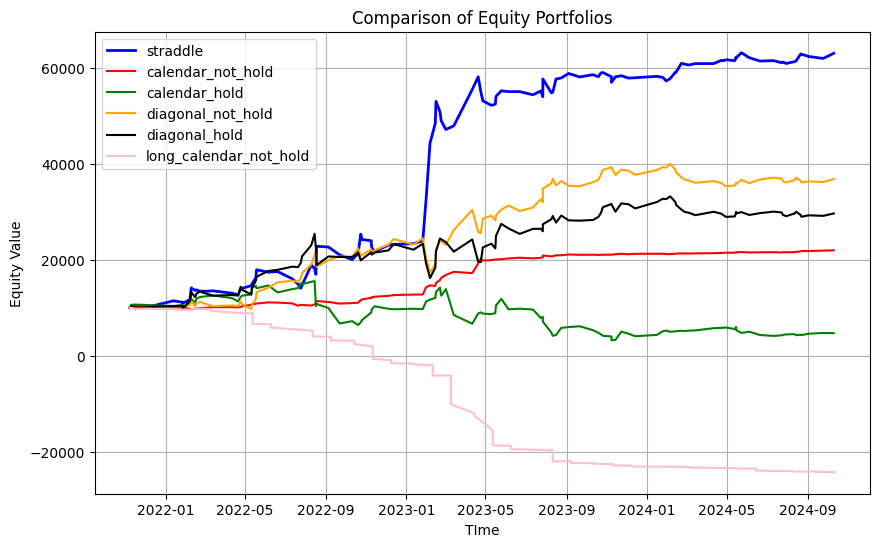

In [616]:
# Create a portfolio with the initial cash
my_portfolio_straddle = Portfolio(10000)
my_portfolio_calendar_not_hold = Portfolio(10000)
my_portfolio_calendar_hold = Portfolio(10000)
my_portfolio_diagonal_not_hold = Portfolio(10000)
my_portfolio_diagonal_hold = Portfolio(10000)
my_portfolio_long_cal =Portfolio(10000)

filtered_df = filtered_df_earning_date
# number of days before earning report
n = 5
bidask_spread = 5
stock = ['NVDA','ORCL','PANW','TGT','NFLX','ANET','AMZN','NKE','DELL','FTNT']
for i in stock:
    for earning_date in filtered_df["Earnings Date"][filtered_df["Symbol"]==i]:
        closest_maturity = df_expiration_date.loc[(df_expiration_date - earning_date).abs().idxmin()] #+1
        longer_maturity = df_expiration_date.loc[(df_expiration_date - earning_date).abs().idxmin()+1] #+2
        if closest_maturity <= earning_date:
            closest_maturity = df_expiration_date.loc[(df_expiration_date - earning_date).abs().idxmin()+1] #+1
            longer_maturity = df_expiration_date.loc[(df_expiration_date - earning_date).abs().idxmin()+2] #+2
        if closest_maturity == pd.Timestamp("2024-11-15"):
            continue
        if longer_maturity >= pd.Timestamp("2024-10-20"):
            longer_maturity = closest_maturity
        my_portfolio_straddle.execute_straddle(i,earning_date,closest_maturity,n,bidask_spread)
        my_portfolio_calendar_not_hold.execute_calendar_not_hold(i,earning_date,closest_maturity,longer_maturity,n,bidask_spread)
        my_portfolio_calendar_hold.execute_calendar_hold(i,earning_date,closest_maturity,longer_maturity,n,bidask_spread)
        my_portfolio_diagonal_not_hold.execure_diagonal_not_hold(i,earning_date,closest_maturity,longer_maturity,n,bidask_spread,10)
        my_portfolio_diagonal_hold.execute_digaonal_hold(i,earning_date,closest_maturity,longer_maturity,n,bidask_spread,10)
        my_portfolio_long_cal.execute_long_calendar_not_hold(i,earning_date,closest_maturity,longer_maturity,n,bidask_spread)

# Print the total equity and PNL
print(f"Total Equity: ${my_portfolio_straddle.equity}")
print(f"Total PNL: ${my_portfolio_straddle.calculate_profit_loss()}")

print(f"Total Equity: ${my_portfolio_calendar_not_hold.equity}")
print(f"Total PNL: ${my_portfolio_calendar_not_hold.calculate_profit_loss()}")

print(f"Total Equity: ${my_portfolio_calendar_hold.equity}")
print(f"Total PNL: ${my_portfolio_calendar_hold.calculate_profit_loss()}")

print(f"Total Equity: ${my_portfolio_diagonal_not_hold.equity}")
print(f"Total PNL: ${my_portfolio_diagonal_not_hold.calculate_profit_loss()}")

print(f"Total Equity: ${my_portfolio_diagonal_hold.equity}")
print(f"Total PNL: ${my_portfolio_diagonal_hold.calculate_profit_loss()}")

print(f"Total Equity: ${my_portfolio_long_cal.equity}")
print(f"Total PNL: ${my_portfolio_long_cal.calculate_profit_loss()}")

plt.figure(figsize=(10, 6))
#Standardise the output result for plotting
equity_history_float = [float(item) for item in my_portfolio_straddle.equity_history]
equity_history_array = np.array(equity_history_float)

#Standardise the result
extracted_dates = []
for item in my_portfolio_straddle.transactions:
    dates = re.findall(r'\d{4}-\d{2}-\d{2}', str(item))
    extracted_dates.extend(dates)
sorted_dates = sorted(extracted_dates)
converted_dates = pd.to_datetime(sorted_dates)

#Plotting the PNL chart
plt.plot(converted_dates, equity_history_array, color='b', linestyle='-',label='straddle', linewidth=2)


equity_history_float = [float(item) for item in my_portfolio_calendar_not_hold.equity_history]
equity_history_array = np.array(equity_history_float)
extracted_dates = []
for item in my_portfolio_calendar_not_hold.transactions:
    dates = re.findall(r'\d{4}-\d{2}-\d{2}', str(item))
    extracted_dates.extend(dates)
sorted_dates = sorted(extracted_dates)
converted_dates = pd.to_datetime(sorted_dates)
plt.plot(converted_dates, equity_history_array, color='r', linestyle='-',label='calendar_not_hold')

equity_history_float = [float(item) for item in my_portfolio_calendar_hold.equity_history]
equity_history_array = np.array(equity_history_float)
extracted_dates = []
for item in my_portfolio_calendar_hold.transactions:
    dates = re.findall(r'\d{4}-\d{2}-\d{2}', str(item))
    extracted_dates.extend(dates)
sorted_dates = sorted(extracted_dates)
converted_dates = pd.to_datetime(sorted_dates)
plt.plot(converted_dates, equity_history_array, color='g', linestyle='-',label='calendar_hold')


equity_history_float = [float(item) for item in my_portfolio_diagonal_not_hold.equity_history]
equity_history_array = np.array(equity_history_float)
extracted_dates = []
for item in my_portfolio_diagonal_not_hold.transactions:
    dates = re.findall(r'\d{4}-\d{2}-\d{2}', str(item))
    extracted_dates.extend(dates)
sorted_dates = sorted(extracted_dates)
converted_dates = pd.to_datetime(sorted_dates)
plt.plot(converted_dates, equity_history_array, color='orange', linestyle='-',label='diagonal_not_hold')

equity_history_float = [float(item) for item in my_portfolio_diagonal_hold.equity_history]
equity_history_array = np.array(equity_history_float)
extracted_dates = []
for item in my_portfolio_diagonal_hold.transactions:
    dates = re.findall(r'\d{4}-\d{2}-\d{2}', str(item))
    extracted_dates.extend(dates)
sorted_dates = sorted(extracted_dates)
converted_dates = pd.to_datetime(sorted_dates)
plt.plot(converted_dates, equity_history_array, color='black', linestyle='-',label='diagonal_hold')

equity_history_float = [float(item) for item in my_portfolio_long_cal.equity_history]
equity_history_array = np.array(equity_history_float)
extracted_dates = []
for item in my_portfolio_long_cal.transactions:
    dates = re.findall(r'\d{4}-\d{2}-\d{2}', str(item))
    extracted_dates.extend(dates)
sorted_dates = sorted(extracted_dates)
converted_dates = pd.to_datetime(sorted_dates)
plt.plot(converted_dates, equity_history_array, color='pink', linestyle='-',label='long_calendar_not_hold')


plt.xlabel('TIme')
plt.ylabel('Equity Value')
plt.title('Comparison of Equity Portfolios')
plt.legend()
plt.grid(True)
plt.show()


/var/folders/rr/glggxg997qbgnyw1d_r00sj80000gn/T/ipykernel_1140/1421162323.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  equity_history_float = [float(item) for item in my_portfolio_calendar_not_hold.equity_history]


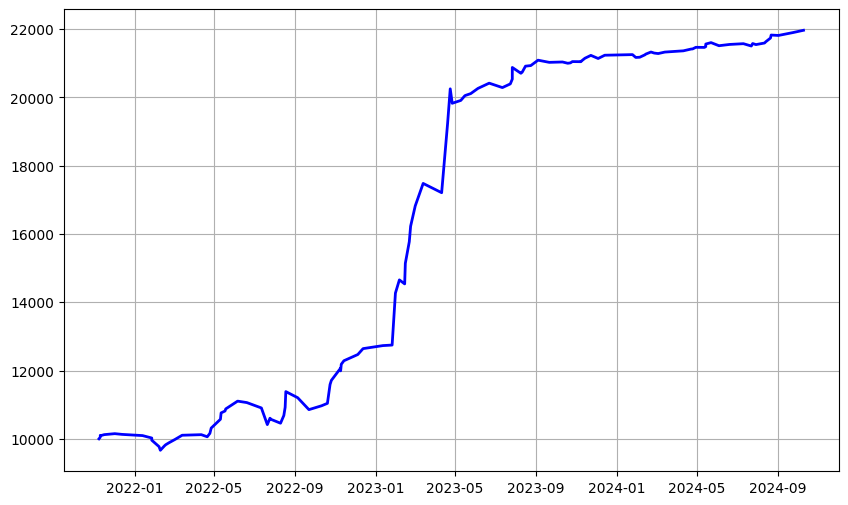

In [605]:
#Standardise the output result for plotting
equity_history_float = [float(item) for item in my_portfolio_calendar_not_hold.equity_history]
equity_history_array = np.array(equity_history_float)
equity_history_array

#Standardise the result
extracted_dates = []
for item in my_portfolio_calendar_not_hold.transactions:
    dates = re.findall(r'\d{4}-\d{2}-\d{2}', str(item))
    extracted_dates.extend(dates)
sorted_dates = sorted(extracted_dates)
converted_dates = pd.to_datetime(sorted_dates)

#Plotting the PNL chart
plt.figure(figsize=(10, 6))
plt.plot(converted_dates, equity_history_array, color='b', linestyle='-',label='straddle', linewidth=2)
plt.grid(True)
plt.show()

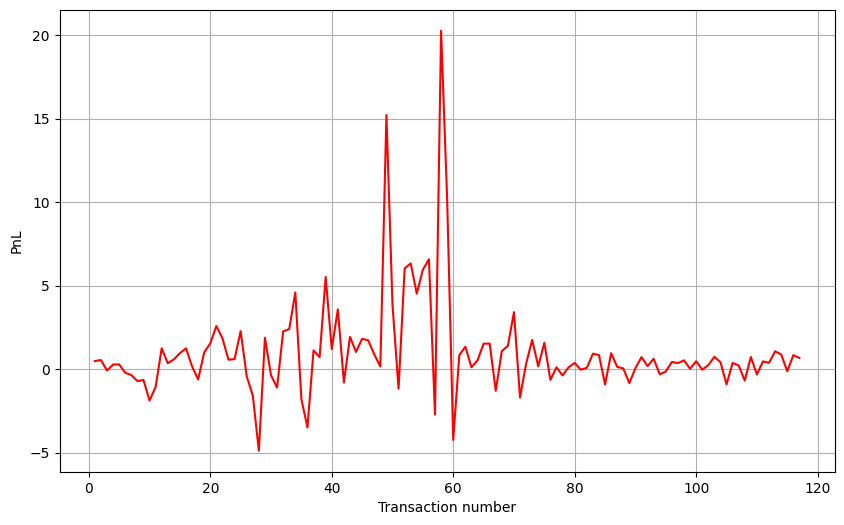

In [606]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(my_portfolio_calendar_not_hold.pnl_history)+1), my_portfolio_calendar_not_hold.pnl_history, color='r', linestyle='-')
plt.xlabel("Transaction number")
plt.ylabel("PnL")
plt.grid(True)
plt.show()

In [531]:
ticker_symbol = '^GSPC'

# Fetch historical stock data for the specified date range
sp500_data = yf.download(ticker_symbol, start='2021-11-10', end='2024-11-06')
sp500_close_prices = sp500_data['Close']
sp500_close_df = pd.DataFrame(sp500_close_prices, columns=['Close'])
sp500_close_df.reset_index(inplace=True)
sp500_close_df.rename(columns={'Date': 'Time'}, inplace=True)
sp500_close_df['Time'] = pd.to_datetime(sp500_close_df['Time'])

# Display the extracted close prices
print(sp500_close_df["Time"])

[*********************100%***********************]  1 of 1 completed

0     2021-11-10
1     2021-11-11
2     2021-11-12
3     2021-11-15
4     2021-11-16
         ...    
746   2024-10-30
747   2024-10-31
748   2024-11-01
749   2024-11-04
750   2024-11-05
Name: Time, Length: 751, dtype: datetime64[ns]


In [558]:
equity_history_float = [float(item) for item in my_portfolio_calendar_not_hold.equity_history]
equity_history_array = np.array(equity_history_float)
equity_history_array

/var/folders/rr/glggxg997qbgnyw1d_r00sj80000gn/T/ipykernel_1140/849520776.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  equity_history_float = [float(item) for item in my_portfolio_calendar_not_hold.equity_history]


array([10000.        , 10000.48623548, 10001.03203842, 10000.95159411,
       10001.23144205, 10001.5167617 , 10001.3031227 , 10000.95432345,
       10000.24240324,  9999.59816075,  9997.71988799,  9996.65075304,
        9997.90420798,  9998.2616156 ,  9998.84794729,  9999.80632395,
       10001.05352097, 10001.22224986, 10000.60703253, 10001.606957  ,
       10003.15437182, 10005.73909474, 10007.59382112, 10008.16012302,
       10008.76670113, 10011.04390936, 10010.61817742, 10009.04516019,
       10004.16314977, 10006.04113965, 10005.67610026, 10004.57539022,
       10006.83814486, 10009.24220802, 10013.83535553, 10012.04359257,
       10008.55415478, 10009.67608156, 10010.39434067, 10015.92070455,
       10017.12783866, 10020.70722133, 10019.90894316, 10021.8423939 ,
       10022.87326529, 10024.69280889, 10026.41964176, 10027.30733299,
       10027.46586756, 10042.69039638, 10046.54662506, 10045.37320439,
       10051.40428549, 10057.7375725 , 10062.26036155, 10068.21531765,
      

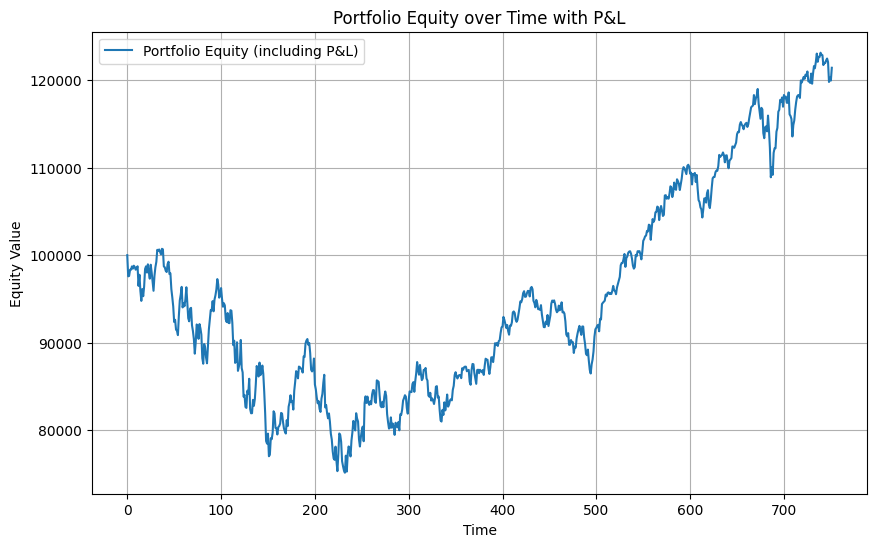

In [590]:
import pandas as pd
import matplotlib.pyplot as plt

class SP500Tracker:
    def __init__(self, equity, stock_price):
        self.cash = 0
        self.equity = equity
        self.equity_history = [self.equity]
        self.stock_price = stock_price
        self.shares = self.equity // self.stock_price
        self.profit_history = [0]
        self.transactions = []
        self.pnl_history = [0]  # Initialize P&L history with zero

    def update_stock_price(self, new_stock_price, trading_date):
        self.stock_price = new_stock_price
        self.transactions.append(trading_date)

    def update_portfolio(self):
        new_equity = self.shares * self.stock_price
        pnl = new_equity - self.equity
        self.equity = new_equity
        self.equity_history.append(self.equity)
        self.pnl_history.append(pnl)

    def track_index_performance(self, new_stock_price):
        profit = (new_stock_price - self.stock_price) * self.shares
        self.profit_history.append(profit)
        self.stock_price = new_stock_price

        return profit

# Example usage:
equity = 100000  # Starting equity
sp500_stock_price = sp500_close_df["Close"][sp500_close_df["Time"] == pd.Timestamp('2021-11-10')].values[0]

sp500_tracker = SP500Tracker(equity,sp500_stock_price)

# Simulate tracking the index performance over time and update equity with P&L
for price in sp500_close_df["Close"]:
    trading_date = sp500_close_df['Time'][sp500_close_df["Close"] == price]
    sp500_tracker.update_stock_price(price, trading_date)
    sp500_tracker.update_equity_portfolio()

extracted_dates = []
for item in sp500_tracker.transactions:
    dates = re.findall(r'\d{4}-\d{2}-\d{2}', str(item))
    extracted_dates.extend(dates)
sorted_dates = sorted(extracted_dates)
converted_dates = pd.to_datetime(sorted_dates)

# Plotting the equity history including P&L
plt.figure(figsize=(10, 6))
plt.plot(sp500_tracker.equity_history, label='Portfolio Equity (including P&L)')
plt.xlabel('Time')
plt.ylabel('Equity Value')
plt.title('Portfolio Equity over Time with P&L')
plt.legend()
plt.grid(True)
plt.show()

In [608]:
sp500_tracker.equity_history

[100000,
 97580.9091796875,
 97634.67041015625,
 98339.85205078125,
 98338.7958984375,
 98718.89794921875,
 98462.068359375,
 98795.3408203125,
 98657.1591796875,
 98341.73876953125,
 98504.7041015625,
 98730.6591796875,
 96487.0224609375,
 97760.67041015625,
 95907.0,
 94773.8408203125,
 96119.10205078125,
 95307.03369140625,
 96425.068359375,
 98421.75,
 98725.4091796875,
 98016.4541015625,
 98952.42041015625,
 98048.37451171875,
 97315.88671875,
 98906.85205078125,
 98042.068359375,
 97033.44287109375,
 95928.42041015625,
 97633.82958984375,
 98627.76123046875,
 99241.5908203125,
 100614.98876953125,
 100513.35205078125,
 100654.26123046875,
 100353.32958984375,
 100089.78369140625,
 100727.76123046875,
 100664.3408203125,
 98712.181640625,
 98617.0458984375,
 98217.62548828125,
 98076.0908203125,
 98974.46630859375,
 99253.35205078125,
 97839.62548828125,
 97919.85205078125,
 96119.30712890625,
 95187.955078125,
 94137.32958984375,
 92356.73876953125,
 92612.7275390625,
 91485.4541

/var/folders/rr/glggxg997qbgnyw1d_r00sj80000gn/T/ipykernel_1140/852925642.py:36: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  number_of_options = min(self.max_options,int(self.cash*0.1 / cost))
/var/folders/rr/glggxg997qbgnyw1d_r00sj80000gn/T/ipykernel_1140/852925642.py:36: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  number_of_options = min(self.max_options,int(self.cash*0.1 / cost))
/var/folders/rr/glggxg997qbgnyw1d_r00sj80000gn/T/ipykernel_1140/852925642.py:36: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  number_of_options = min(self.max_options,int(self.cash*0.1 / cost))
/var/folders/rr/glggxg997qbgnyw1d_r00sj80000gn/T/ipykernel_1140/852925642.py:36: FutureWarning: Calling int on a single element Se

ValueError: Input could not be cast to an at-least-1D NumPy array

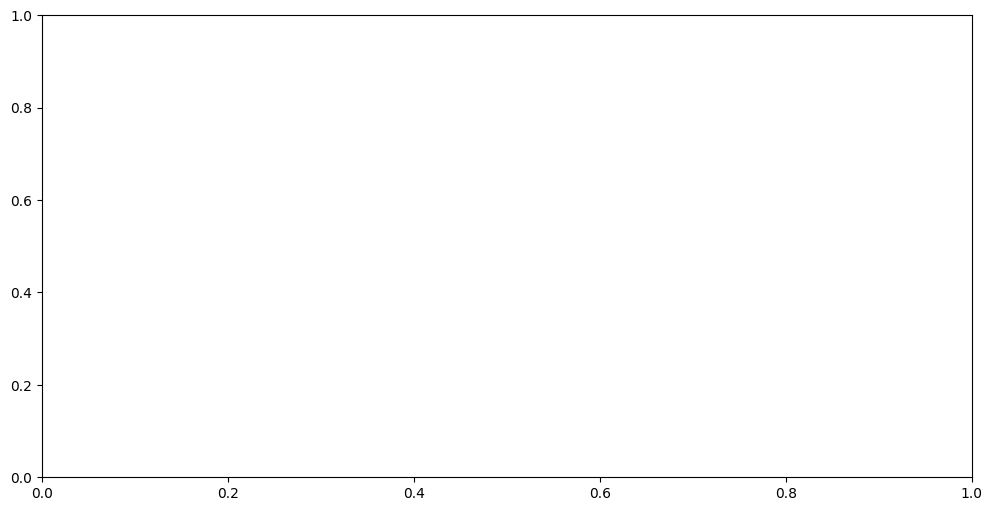

In [591]:
class PortfolioAnalyzer:
    def __init__(self, sp500_equity, sp500_stock_price, options_cash):
        self.sp500_tracker = SP500Tracker(equity=sp500_equity, stock_price=sp500_stock_price)  # 90% allocated to S&P 500
        self.options_portfolio = Portfolio(cash=options_cash)  # 10% allocated to options trading
        self.equity_history = [sp500_equity + options_cash]

    def simulate_and_plot_equity_history(self):
        filtered_df = filtered_df_earning_date
        # number of days before earning report
        n = 5
        bidask_spread = 10
        stock = ['NVDA','ORCL','PANW','TGT','NFLX','ANET','AMZN','NKE','DELL','FTNT']
        for i in stock:
            for earning_date in filtered_df["Earnings Date"][filtered_df["Symbol"]==i]:
                closest_maturity = df_expiration_date.loc[(df_expiration_date - earning_date).abs().idxmin()] #+1
                longer_maturity = df_expiration_date.loc[(df_expiration_date - earning_date).abs().idxmin()+1] #+2
                if closest_maturity <= earning_date:
                    closest_maturity = df_expiration_date.loc[(df_expiration_date - earning_date).abs().idxmin()+1] #+1
                    longer_maturity = df_expiration_date.loc[(df_expiration_date - earning_date).abs().idxmin()+2] #+2
                if closest_maturity == pd.Timestamp("2024-11-15"):
                    continue
                if longer_maturity >= pd.Timestamp("2024-10-20"):
                    longer_maturity = closest_maturity
                self.options_portfolio.execute_calendar_not_hold(i,earning_date,closest_maturity,longer_maturity,n,bidask_spread)

        # Rebalance S&P 500 portfolio daily
        for price in sp500_close_df["Close"]:
            trading_date = sp500_close_df['Time'][sp500_close_df["Close"] == price]
            self.sp500_tracker.update_stock_price(price, trading_date)
            self.sp500_tracker.update_portfolio()
        
        # Calculate total equity for the day
        total_equity = self.sp500_tracker.equity + self.options_portfolio.equity
        self.equity_history.append(total_equity)

        # Plotting the graph
        plt.figure(figsize=(12, 6))
        plt.plot(self.equity_history, color='b', label='Total Equity')
        plt.title('Total Equity History of Balanced Portfolio')
        plt.xlabel('Days')
        plt.ylabel('Equity Value')
        plt.legend()
        plt.grid(True)
        plt.show()

# Example Usage
sp500_stock_price = sp500_close_df["Close"][sp500_close_df["Time"] == pd.Timestamp('2021-11-10')].values[0]
analyzer = PortfolioAnalyzer(90000, sp500_stock_price, 10000)
analyzer.simulate_and_plot_equity_history()

In [547]:
PortfolioAnalyzer.equity_history

AttributeError: type object 'PortfolioAnalyzer' has no attribute 'equity_history'